In this practical assignment you will learn how to train a recurrent neural network for language generation in chainer. Always show how you arrived at your answer. Hand in your assignment by adding the solutions to this notebook file.

We provide most of the code needed for this assignment. The assignment is based on https://github.com/pfnet/chainer/blob/master/examples/ptb/train_ptb.py. We start by defining a neural network for language generation. Note that this network combines a word embedding layer (mapping word indices to dense vectors) with an LSTM layer (capturing word dynamics) and a linear output layer (yielding the word probabilities via a Classifier object's softmax layer).

In [1]:
from __future__ import division
from __future__ import print_function
import argparse

import numpy as np

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

# Definition of a recurrent net for language modeling
class RNNForLM(chainer.Chain):

    def __init__(self, n_vocab, n_units, train=True):
        super(RNNForLM, self).__init__(
            embed=L.EmbedID(n_vocab, n_units),
            l1=L.LSTM(n_units, n_units),
            l2=L.LSTM(n_units, n_units),
            l3=L.Linear(n_units, n_vocab),
        )
        for param in self.params():
            param.data[...] = np.random.uniform(-0.1, 0.1, param.data.shape)
        self.train = train

    def reset_state(self):
        self.l1.reset_state()
        self.l2.reset_state()

    def __call__(self, x):
        h0 = self.embed(x)
        h1 = self.l1(F.dropout(h0, train=self.train))
        h2 = self.l2(F.dropout(h1, train=self.train))
        y = self.l3(F.dropout(h2, train=self.train))
        return y

We need to define a custom iterator to deal with this data.

In [2]:
# Dataset iterator to create a batch of sequences at different positions.
# This iterator returns a pair of current words and the next words. Each
# example is a part of sequences starting from the different offsets
# equally spaced within the whole sequence.
class ParallelSequentialIterator(chainer.dataset.Iterator):

    def __init__(self, dataset, batch_size, repeat=True):
        self.dataset = dataset
        self.batch_size = batch_size  # batch size
        # Number of completed sweeps over the dataset. In this case, it is
        # incremented if every word is visited at least once after the last
        # increment.
        self.epoch = 0
        # True if the epoch is incremented at the last iteration.
        self.is_new_epoch = False
        self.repeat = repeat
        length = len(dataset)
        # Offsets maintain the position of each sequence in the mini-batch.
        self.offsets = [i * length // batch_size for i in range(batch_size)]
        # NOTE: this is not a count of parameter updates. It is just a count of
        # calls of ``__next__``.
        self.iteration = 0

    def __next__(self):
        # This iterator returns a list representing a mini-batch. Each item
        # indicates a different position in the original sequence. Each item is
        # represented by a pair of two word IDs. The first word is at the
        # "current" position, while the second word at the next position.
        # At each iteration, the iteration count is incremented, which pushes
        # forward the "current" position.
        length = len(self.dataset)
        if not self.repeat and self.iteration * self.batch_size >= length:
            # If not self.repeat, this iterator stops at the end of the first
            # epoch (i.e., when all words are visited once).
            raise StopIteration
        cur_words = self.get_words()
        self.iteration += 1
        next_words = self.get_words()

        epoch = self.iteration * self.batch_size // length
        self.is_new_epoch = self.epoch < epoch
        if self.is_new_epoch:
            self.epoch = epoch

        return list(zip(cur_words, next_words))

    @property
    def epoch_detail(self):
        # Floating point version of epoch.
        return self.iteration * self.batch_size / len(self.dataset)

    def get_words(self):
        # It returns a list of current words.
        return [self.dataset[(offset + self.iteration) % len(self.dataset)]
                for offset in self.offsets]

    def serialize(self, serializer):
        # It is important to serialize the state to be recovered on resume.
        self.iteration = serializer('iteration', self.iteration)
        self.epoch = serializer('epoch', self.epoch)

We also need to define an updater which runs backpropagation through time.

In [3]:
# Custom updater for truncated BackProp Through Time (BPTT)
class BPTTUpdater(training.StandardUpdater):

    def __init__(self, train_iter, optimizer, bprop_len, device):
        # bprop_len = Number of words in each mini-batch (= length of truncated BPTT)
        
        super(BPTTUpdater, self).__init__(
            train_iter, optimizer, device=device)
        self.bprop_len = bprop_len

    # The core part of the update routine can be customized by overriding.
    def update_core(self):
        loss = 0
        # When we pass one iterator and optimizer to StandardUpdater.__init__,
        # they are automatically named 'main'.
        train_iter = self.get_iterator('main')
        optimizer = self.get_optimizer('main')
        
        # Progress the dataset iterator for bprop_len words at each iteration.
        for i in range(self.bprop_len):
            # Get the next batch (a list of tuples of two word IDs)
            batch = train_iter.__next__()

            # Concatenate the word IDs to matrices and send them to the device
            # self.converter does this job
            # (it is chainer.dataset.concat_examples by default)
            x, t = self.converter(batch, self.device)

            # Compute the loss at this time step and accumulate it
            loss += optimizer.target(chainer.Variable(x), chainer.Variable(t))

        optimizer.target.cleargrads()  # Clear the parameter gradients
        loss.backward()  # Backprop
        loss.unchain_backward()  # Truncate the graph
        optimizer.update()  # Update the parameters

We load the Penn tree bank text dataset.

In [4]:
# Load the Penn Tree Bank long word sequence dataset
train, val, test = chainer.datasets.get_ptb_words()
n_vocab = max(train) + 1  # train is just an array of integers

# Reduce to first 1000 words to speed up
train = train[:1000]
val = val[:1000]
test = test[:1000]

We want to compute the change in perplexity to get a measure of model performance.

In [5]:
# Routine to rewrite the result dictionary of LogReport to add perplexity values
def compute_perplexity(result):
    result['perplexity'] = np.exp(result['main/loss'])
    if 'validation/main/loss' in result:
        result['val_perplexity'] = np.exp(result['validation/main/loss'])

In [6]:
# Define iterators
train_iter = ParallelSequentialIterator(train, batch_size=100)
val_iter = ParallelSequentialIterator(val, 1, repeat=False)
test_iter = ParallelSequentialIterator(test, 1, repeat=False)

# Prepare an RNNLM model with 100 LSTM units
rnn = RNNForLM(n_vocab, 100)
model = L.Classifier(rnn)

# Set up an optimizer
optimizer = chainer.optimizers.SGD(lr=1.0)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(5))

# Set up a trainer
updater = BPTTUpdater(train_iter, optimizer, bprop_len=35, device=-1)
trainer = training.Trainer(updater, (100, 'epoch'), out='result')

# Model with shared params and distinct states on which we evaluate the validation data
eval_model = model.copy()
eval_rnn = eval_model.predictor
eval_rnn.train = False
trainer.extend(extensions.Evaluator(
    val_iter, eval_model, device=-1,
    # Reset the RNN state at the beginning of each evaluation
    eval_hook=lambda _: eval_rnn.reset_state()))

# Add things to report
trainer.extend(extensions.LogReport(postprocess=compute_perplexity,
                                    trigger=(1, 'epoch')))
trainer.extend(extensions.PrintReport(
    ['epoch', 'perplexity', 'val_perplexity']
), trigger=(1, 'epoch'))

trainer.run()

epoch       perplexity  val_perplexity
3           10047.2     5843.44         
7           5615.32     2996.96         
10          3368.28     4684.92         
14          4171.62     2883.17         
17          3294.54     3153.98         
21          2536.81     2510.58         
24          2409.47     2834.33         
28          2051.36     1981.68         
31          1647.49     2521.9          
35          1709.71     2298.31         
38          1553.5      2210.9          
42          1239.9      2249.52         
45          1806.64     2360.3          
49          1000.64     2015.17         
52          1067.15     6237.5          
56          1991.87     2073.07         
59          938.669     4173.4          
63          1685.05     2001.06         
66          1164.85     2297.18         
70          653.808     1834.88         
73          968.005     2513.62         
77          924.807     2145.96         
80          888.545     2135.98         
84          611.32

We will use the trained model for language generation. We will use converter from index notation to word identity. 

In [7]:
word_to_idx = chainer.datasets.get_ptb_words_vocabulary()

# create reverse vocabulary
idx_to_word = {}
for k in word_to_idx.keys():
    idx_to_word[word_to_idx[k]] = k

## Exercise 1 (3 points)

Now write code to generate words using the predictor of the trained model. Ensure to set the *train* field of the predictor to *False*. This ensures that the dropout layer (as used in the model) works correctly. Generate new words by probabilistically selecting a new word using the predictor. Note that the outputs of the predictor need to be converted first to probabilities using a ```softmax``` function. To probabilistically select a new word, use ```numpy.random.multinomial```.

In [31]:
pred = model.predictor
pred.train = False



prediction = F.softmax(pred(train[[np.random.randint(0,1000)]]).data).data 
sample = np.random.multinomial(1, prediction[0,:], size=1)
idx = list((sample == 1).T).index(True)
generated_word = idx_to_word[idx]
print(generated_word)

reported


## Exercise 2 (2 points)

Use your code to generate a list of 30 words. Does it resemble written text? Why (not)? Explain your answer. What is needed to further improve text generation?

In [32]:
random_words = []

for i in range(30):
    idx = list((sample == 1).T).index(True)
    gen_word = idx_to_word[idx]
    random_words.append(gen_word)
    prediction = F.softmax(pred(np.array([word_to_idx[gen_word]]))).data 
    sample = np.random.multinomial(1, prediction[0,:], size=1)

print(' '.join(random_words))


reported years some arteries will robots marlin sold support that adjusted realist at maturity budgetary role asbestos cities\/abc in of layer five faberge seven deaths were 're to yields beverage


By training the recurrent neural network, you implicitly learnt a word embedding. Use the code below to get the dense 100D word representations.

In [33]:
words = np.unique(train)
ann = model.predictor

X = ann.embed(np.array(words,dtype='int32')).data

## Exercise 3 (5 points)

Now run a PCA analysis such that each word is mapped to a 2D representational space. Use the scikit-learn library to achieve this (http://scikit-learn.org). Also add the locations of the following four concepts explicitly to your scatter plot using different colours: *smokers*, *cancer*, *portfolio*, *market*. Do the representations in this 2D space make sense? Why (not)?

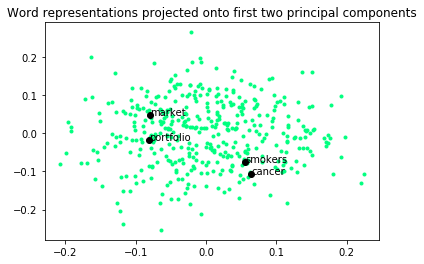

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
new_X = pca.fit_transform(X)

import matplotlib.pyplot as plt
plt.plot(new_X[:,0],new_X[:,1], '.', color = 'springgreen')

plt.plot(new_X[word_to_idx['smokers']][0], new_X[word_to_idx['smokers']][1], 'o', color ='k')
plt.annotate('smokers', new_X[word_to_idx['smokers']])

plt.plot(new_X[word_to_idx['cancer']][0], new_X[word_to_idx['cancer']][1], 'o', color ='k')
plt.annotate('cancer', new_X[word_to_idx['cancer']])

plt.plot(new_X[word_to_idx['portfolio']][0], new_X[word_to_idx['portfolio']][1], 'o', color ='k')
plt.annotate('portfolio', new_X[word_to_idx['portfolio']])

plt.plot(new_X[word_to_idx['market']][0], new_X[word_to_idx['market']][1], 'o', color ='k')
plt.annotate('market', new_X[word_to_idx['market']])

plt.title('Word representations projected onto first two principal components')
plt.show()